In [1]:
import xgboost as xgb
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import gc
import shap
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def gini(actual, pred, cmpcol = 0, sortcol = 1):
    assert( len(actual) == len(pred) )
    all = np.asarray(np.c_[ actual, pred, np.arange(len(actual)) ], dtype=float)
    all = all[ np.lexsort((all[:,2], -1*all[:,1])) ]
    totalLosses = all[:,0].sum()
    giniSum = all[:,0].cumsum().sum() / totalLosses
    
    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)
 
def gini_normalized(a, p):
    return gini(a, p) / gini(a, a)

In [3]:
train = pd.read_csv('../input/train.csv.zip')
test = pd.read_csv('../input/test.csv.zip')
sample_submission = pd.read_csv('../input/sample_submission.csv.zip')

In [4]:
train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


In [5]:
features = train.columns[2:]

In [6]:
features

Index(['ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03', 'ps_ind_04_cat',
       'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin',
       'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin',
       'ps_ind_13_bin', 'ps_ind_14', 'ps_ind_15', 'ps_ind_16_bin',
       'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_reg_01', 'ps_reg_02', 'ps_reg_03',
       'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat',
       'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat',
       'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat', 'ps_car_11',
       'ps_car_12', 'ps_car_13', 'ps_car_14', 'ps_car_15', 'ps_calc_01',
       'ps_calc_02', 'ps_calc_03', 'ps_calc_04', 'ps_calc_05', 'ps_calc_06',
       'ps_calc_07', 'ps_calc_08', 'ps_calc_09', 'ps_calc_10', 'ps_calc_11',
       'ps_calc_12', 'ps_calc_13', 'ps_calc_14', 'ps_calc_15_bin',
       'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin', 'ps_calc_19_bin',
       'ps_calc_20_bin'],
      dtype='obj

In [8]:
for feature in features:
    print(len(np.unique(train[feature].values)))

8
5
12
3
8
2
2
2
2
2
2
2
2
5
14
2
2
2
10
19
5013
13
3
3
10
3
18
3
2
6
3
104
5
184
70482
850
15
10
10
10
6
7
11
10
11
8
26
20
11
14
24
2
2
2
2
2
2


In [9]:
for feature in features:
    print(len(np.unique(test[feature].values)))

8
5
12
3
8
2
2
2
2
2
2
2
2
5
14
2
2
2
10
19
5046
13
3
3
10
3
18
3
2
6
3
104
5
201
83769
885
15
10
10
10
6
7
10
10
12
8
26
21
11
16
25
2
2
2
2
2
2


In [10]:
X = train[features]
X_test = test[features]
Y = train.target.values

In [12]:
params = {'objective': 'binary:logistic',
 'tree_method': 'gpu_hist',
 'lambda': 4.645511,
 'alpha': 0.654147,
 'colsample_bytree': 0.917,
 'subsample': 0.66,
 'learning_rate': 0.013,
 'max_depth': 7,
 'min_child_weight': 194,
 'eval_metric': 'logloss'}

In [13]:
dtest = xgb.DMatrix(X_test, enable_categorical=True)

In [22]:
%%time
train_oof = np.zeros((X.shape[0], ))
test_preds = 0
train_oof.shape
num_round = 1000

n_splits = 5
kf = KFold(n_splits=n_splits, random_state=137, shuffle=True)

for jj, (train_index, val_index) in enumerate(kf.split(X)):
    if jj == 0:
        print("Fitting fold", jj+1)
        train_features = X.loc[train_index]
        train_target = Y[train_index]

        val_features = X.loc[val_index]
        val_target = Y[val_index]

        dtrain = xgb.DMatrix(train_features, train_target, enable_categorical=True)
        dval = xgb.DMatrix(val_features, val_target, enable_categorical=True)

        model = xgb.train(params, dtrain, num_round)
        #model.set_param({'predictor': 'cpu_predictor'})
        val_pred = model.predict(dval)
        train_oof[val_index] = val_pred
        print("Fold normalized:", gini_normalized(val_target, val_pred))
        #test_preds += model.predict(dtest)/n_splits
        #del train_features, train_target, val_features, val_target
        #gc.collect()

Fitting fold 1
Fold normalized: 0.2857341685206029
CPU times: user 17 s, sys: 982 ms, total: 18 s
Wall time: 5.72 s


In [23]:
%%time
shap_preds = model.predict(dval, pred_contribs=True)

CPU times: user 1.32 s, sys: 389 ms, total: 1.71 s
Wall time: 1.7 s


In [24]:
%%time
shap_interactions = model.predict(dval, pred_interactions=True)

CPU times: user 13.4 s, sys: 4.49 s, total: 17.9 s
Wall time: 17.9 s


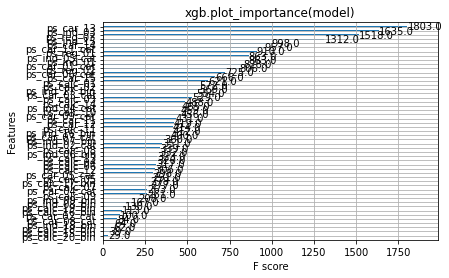

In [35]:
xgb.plot_importance(model)
plt.title("xgb.plot_importance(model)")
plt.show()

In [25]:
shap.initjs()

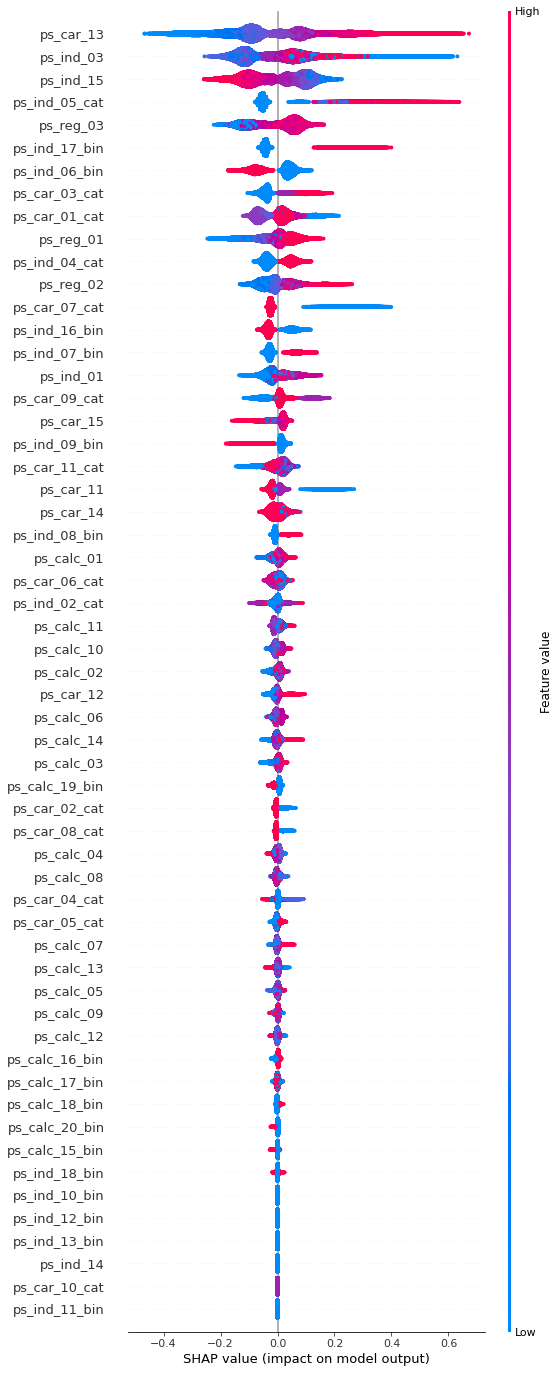

In [30]:
shap.summary_plot(shap_preds[:,:-1], val_features, max_display=57)

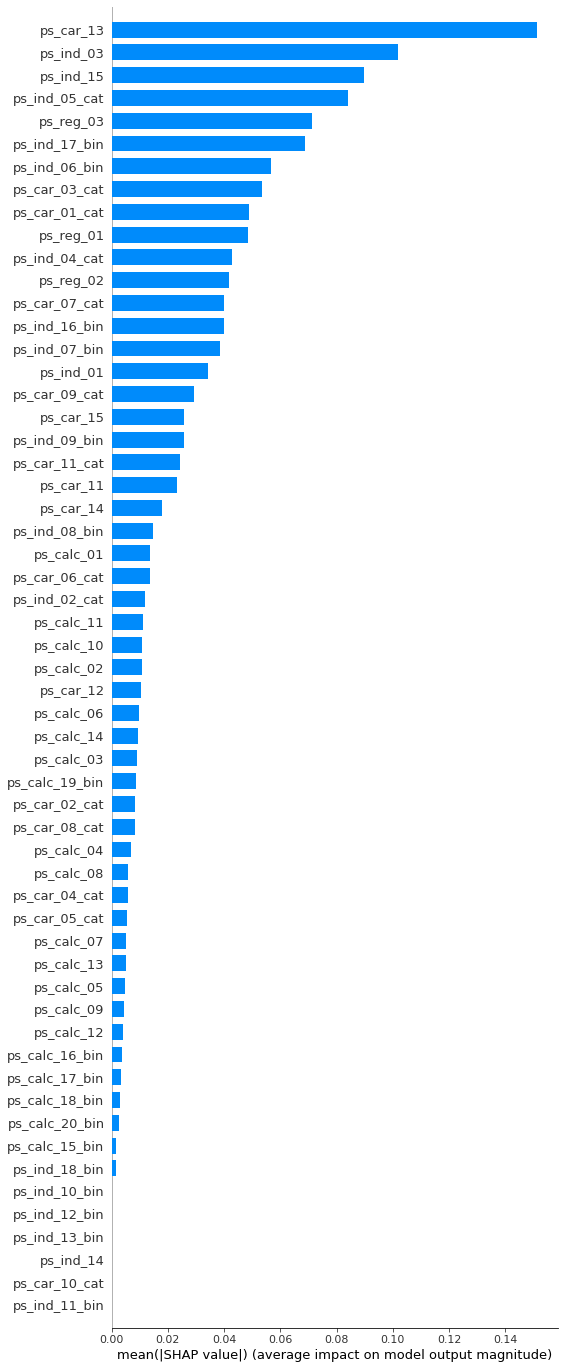

In [34]:
shap.summary_plot(shap_preds[:,:-1], val_features, plot_type="bar", max_display=57)

In [32]:
np.abs(shap_preds).sum(axis=0)

array([4.0984219e+03, 1.4275542e+03, 1.2136905e+04, 5.0810654e+03,
       1.0002108e+04, 6.7522920e+03, 4.5842178e+03, 1.7684987e+03,
       3.0470662e+03, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 1.0699994e+04, 4.7562681e+03,
       8.2063662e+03, 1.8795482e+02, 5.7562280e+03, 4.9757251e+03,
       8.4907764e+03, 5.8290474e+03, 9.8338696e+02, 6.3589668e+03,
       6.7398438e+02, 6.4831152e+02, 1.6191409e+03, 4.7636558e+03,
       9.7380780e+02, 3.4681892e+03, 0.0000000e+00, 2.9035469e+03,
       2.7843406e+03, 1.2611857e+03, 1.7992689e+04, 2.1134912e+03,
       3.0484797e+03, 1.6337672e+03, 1.2847091e+03, 1.0946440e+03,
       8.1027307e+02, 5.5332733e+02, 1.1611857e+03, 6.1564545e+02,
       7.0320557e+02, 5.2492798e+02, 1.2879810e+03, 1.3127737e+03,
       5.0249487e+02, 6.0741248e+02, 1.1364413e+03, 1.9837328e+02,
       4.4684824e+02, 3.8658417e+02, 3.6979617e+02, 1.0533447e+03,
       3.1582446e+02, 3.9066922e+05], dtype=float32)

In [38]:
mean_abs_shap_values = np.abs(shap_preds).sum(axis=0)[:-1]

In [39]:
mean_abs_shap_values.shape

(57,)

In [40]:
np.sort(mean_abs_shap_values)

array([    0.     ,     0.     ,     0.     ,     0.     ,     0.     ,
           0.     ,   187.95482,   198.37328,   315.82446,   369.79617,
         386.58417,   446.84824,   502.49487,   524.928  ,   553.32733,
         607.4125 ,   615.64545,   648.3115 ,   673.9844 ,   703.20557,
         810.2731 ,   973.8078 ,   983.38696,  1053.3447 ,  1094.644  ,
        1136.4413 ,  1161.1857 ,  1261.1857 ,  1284.7091 ,  1287.981  ,
        1312.7737 ,  1427.5542 ,  1619.1409 ,  1633.7672 ,  1768.4987 ,
        2113.4912 ,  2784.3406 ,  2903.5469 ,  3047.0662 ,  3048.4797 ,
        3468.1892 ,  4098.422  ,  4584.218  ,  4756.268  ,  4763.656  ,
        4975.725  ,  5081.0654 ,  5756.228  ,  5829.0474 ,  6358.967  ,
        6752.292  ,  8206.366  ,  8490.776  , 10002.108  , 10699.994  ,
       12136.905  , 17992.69   ], dtype=float32)

In [43]:
faulty_columns = np.where(mean_abs_shap_values == 0)[0]

In [45]:
features[faulty_columns]

Index(['ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin',
       'ps_ind_14', 'ps_car_10_cat'],
      dtype='object')

In [46]:
new_features = list(filter(lambda x: x not in features[faulty_columns], features))

In [48]:
%%time
train_oof = np.zeros((X.shape[0], ))
test_preds = 0
train_oof.shape
num_round = 1000

n_splits = 5
kf = KFold(n_splits=n_splits, random_state=137, shuffle=True)

for jj, (train_index, val_index) in enumerate(kf.split(X)):
    if jj == 0:
        print("Fitting fold", jj+1)
        train_features = X.loc[train_index][new_features]
        train_target = Y[train_index]

        val_features = X.loc[val_index][new_features]
        val_target = Y[val_index]

        dtrain = xgb.DMatrix(train_features, train_target, enable_categorical=True)
        dval = xgb.DMatrix(val_features, val_target, enable_categorical=True)

        model = xgb.train(params, dtrain, num_round)
        #model.set_param({'predictor': 'cpu_predictor'})
        val_pred = model.predict(dval)
        train_oof[val_index] = val_pred
        print("Fold normalized:", gini_normalized(val_target, val_pred))
        #test_preds += model.predict(dtest)/n_splits
        #del train_features, train_target, val_features, val_target
        #gc.collect()

Fitting fold 1
Fold normalized: 0.2859783323638583
CPU times: user 16 s, sys: 839 ms, total: 16.8 s
Wall time: 5.25 s


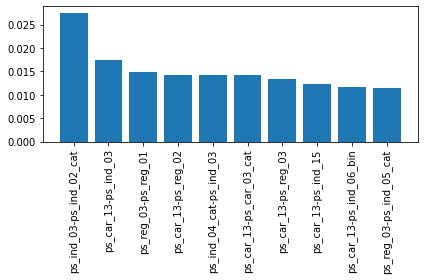

In [51]:
def plot_top_k_interactions(feature_names, shap_interactions, k):
    # Get the mean absolute contribution for each feature interaction
    aggregate_interactions = np.mean(np.abs(shap_interactions[:, :-1, :-1]), axis=0)
    interactions = []
    for i in range(aggregate_interactions.shape[0]):
        for j in range(aggregate_interactions.shape[1]):
            if j < i:
                interactions.append(
                    (feature_names[i] + "-" + feature_names[j], aggregate_interactions[i][j] * 2))
    # sort by magnitude
    interactions.sort(key=lambda x: x[1], reverse=True)
    interaction_features, interaction_values = map(tuple, zip(*interactions))
    plt.bar(interaction_features[:k], interaction_values[:k])
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()
    
    return interactions
    
top_interactions = plot_top_k_interactions(features, shap_interactions, 10)


In [53]:
top_interactions[:5]

[('ps_ind_03-ps_ind_02_cat', 0.027517739683389664),
 ('ps_car_13-ps_ind_03', 0.017510201781988144),
 ('ps_reg_03-ps_reg_01', 0.014807731844484806),
 ('ps_car_13-ps_reg_02', 0.014306033961474895),
 ('ps_ind_04_cat-ps_ind_03', 0.014167144894599915)]

In [54]:
train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


In [56]:
train['ps_ind_03'].values

array([ 5,  7,  9, ..., 10,  3,  8])

In [60]:
train['ps_ind_02_cat'].values

array([2, 1, 4, ..., 1, 2, 1])

In [67]:
train['ps_ind_03-ps_ind_02_cat'] = train['ps_ind_03']*train['ps_ind_02_cat']

In [68]:
train['ps_ind_03-ps_ind_02_cat']

0         10
1          7
2         36
3          2
4          0
          ..
595207    10
595208     3
595209    10
595210     6
595211     8
Name: ps_ind_03-ps_ind_02_cat, Length: 595212, dtype: int64

In [69]:
new_features_2 = new_features + ['ps_ind_03-ps_ind_02_cat']

In [70]:
X = train[new_features_2]

In [71]:
%%time
train_oof = np.zeros((X.shape[0], ))
test_preds = 0
train_oof.shape
num_round = 1000

n_splits = 5
kf = KFold(n_splits=n_splits, random_state=137, shuffle=True)

for jj, (train_index, val_index) in enumerate(kf.split(X)):
    if jj == 0:
        print("Fitting fold", jj+1)
        train_features = X.loc[train_index]
        train_target = Y[train_index]

        val_features = X.loc[val_index]
        val_target = Y[val_index]

        dtrain = xgb.DMatrix(train_features, train_target, enable_categorical=True)
        dval = xgb.DMatrix(val_features, val_target, enable_categorical=True)

        model = xgb.train(params, dtrain, num_round)
        #model.set_param({'predictor': 'cpu_predictor'})
        val_pred = model.predict(dval)
        train_oof[val_index] = val_pred
        print("Fold normalized:", gini_normalized(val_target, val_pred))
        #test_preds += model.predict(dtest)/n_splits
        #del train_features, train_target, val_features, val_target
        #gc.collect()

Fitting fold 1
Fold normalized: 0.28718895468559025
CPU times: user 14.9 s, sys: 776 ms, total: 15.7 s
Wall time: 5.05 s


In [72]:
%%time
shap_preds_2 = model.predict(dval, pred_contribs=True)

CPU times: user 1.25 s, sys: 380 ms, total: 1.63 s
Wall time: 1.63 s


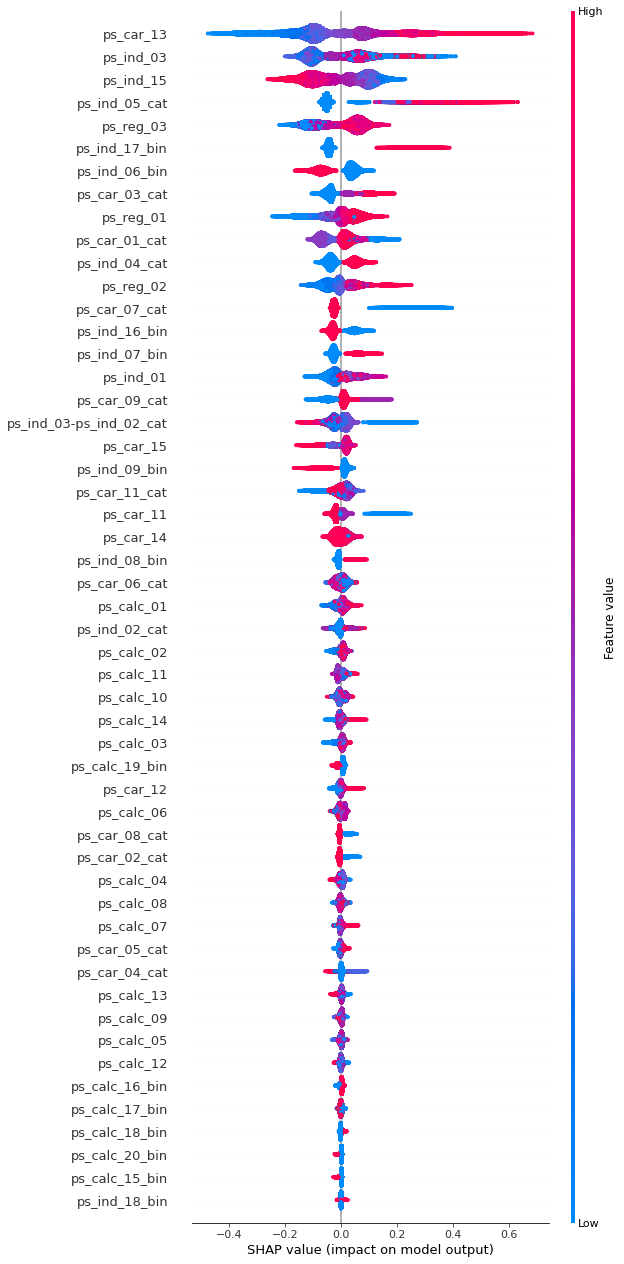

In [73]:
shap.summary_plot(shap_preds_2[:,:-1], val_features, max_display=57)